In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from os import path
import xarray as xr
from matplotlib.colors import Normalize
import sys
#from mpl_toolkits.basemap import Basemap
from collections import Counter
from sklearn.linear_model import LinearRegression
sys.path.append('/Users/hawbecke/Code/Python/')
from mmctools.helper_functions import calc_uv
from mmctools.helper_functions import calc_wind
from mmctools.wrf.utils import Tower, tsout_seriesReader
from pydicts.obsdict import read_AWOS, AWOS_to_ds
from pydicts.baybreezedict import DetectBayBreeze, spatial_breeze_check, find_onshore_minmax
#import pygrib

from cfgrib.xarray_store import open_dataset
#from sklearn.linear_model import LinearRegression
#import skimage.morphology

from datetime import date


In [4]:
obs_dir = '/Users/hawbecke/Research/Chesapeake/Data/Obs/'
awos_ds = xr.open_dataset('{}AWOS/AWOS_2019to2020.nc'.format(obs_dir))
asos_ds = xr.open_dataset('{}ASOS/ASOS_2019to2020.nc'.format(obs_dir))

# Add APG data into AWOS
apg_ds  = xr.open_dataset('{}APG/APG_data_2019.nc'.format(obs_dir))
apg_stn_list = list(apg_ds.station.data)
for ss,apg_stn in enumerate(apg_stn_list):
    if apg_stn == 'PAA':
        apg_stn_list[ss] = 'APG'
apg_ds = apg_ds.assign_coords({'station': apg_stn_list})
non_apg_list = apg_stn_list.copy()
non_apg_list.remove('APG')
apg_ds = apg_ds.drop_sel(station=non_apg_list)
apg_ds = apg_ds.drop(['rh','gust','radt','rain','alt'])

temp = awos_ds.sel(station='APG').combine_first(apg_ds)
temp = temp.squeeze()
temp = temp.expand_dims('station')

lat_da = xr.DataArray([float(apg_ds.lat)], dims=('station'))
lon_da = xr.DataArray([float(apg_ds.lon)], dims=('station'))

temp = temp.assign_coords({'lat':lat_da})
temp = temp.assign_coords({'lon':lon_da})

awos_ds = awos_ds.drop_sel(station=['APG'])

awos_ds = xr.merge([awos_ds,temp])

near_shore_stations = ['APG', 'BWI', 'MTN', 'NAK', 'NHK', 'NUI']

# HRRR

In [5]:
hrrr_dir = '/Users/hawbecke/Research/Chesapeake/Data/HRRR/'
hrrr_files = sorted(glob.glob('{}forecast/hrrr.*.nc'.format(hrrr_dir)))
#hrrr_files = sorted(glob.glob('{}te*.nc'.format(hrrr_dir)))

#### Convert grib2 files with:

    ncl 'fname="hrrr.t16z.wrfsfcf00"' grib2ncdf.ncl

In [12]:
hrrr_files[0]

'/Users/hawbecke/Research/Chesapeake/Data/HRRR/forecast/hrrr.20190716.t06z.wrfsfcf07.nc'

In [6]:
hrrrMD = xr.open_dataset(hrrr_files[0])
land_mask  = np.squeeze(hrrrMD.LAND_P0_L1_GLC0)
hgt        = np.squeeze(hrrrMD.HGT_P0_L1_GLC0)
water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
lat  = hrrrMD.gridlat_0
lon  = hrrrMD.gridlon_0

In [7]:
stn_dict = {}
for ss,stn in enumerate(near_shore_stations):
    stn_dict[stn] = {}
    #if stn == 'APG':
    #    stn_ds = apg_ds.sel(station=stn)
    if stn in awos_ds.station:
        stn_ds = awos_ds.sel(station=stn)
    elif stn in asos_ds.station:
        stn_ds = asos_ds.sel(station=stn)
    stn_lat = stn_ds.lat.data
    stn_lon = stn_ds.lon.data
    dist_from_stn = ((lon-stn_lon)**2 + (lat-stn_lat)**2)**0.5
    stn_j,stn_i = np.where(dist_from_stn == np.nanmin(dist_from_stn))
    stn_j = int(stn_j)
    stn_i = int(stn_i)
    if land_mask.sel(ygrid_0=stn_j,xgrid_0=stn_i) == 0.0:
        if stn == 'NAK':
            stn_i -=1
        elif stn == 'NHK':
            stn_j -= 1
    stn_dict[stn]['lat'] = float(stn_ds.lat.data)
    stn_dict[stn]['lon'] = float(stn_ds.lon.data)
    stn_dict[stn]['i'] = stn_i
    stn_dict[stn]['j'] = stn_j


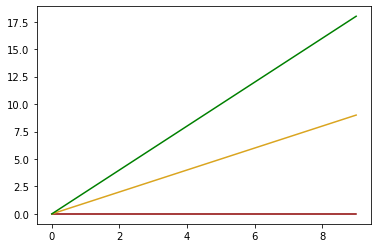

In [8]:
breeze_cmap = plt.cm.RdYlGn(np.linspace(0.1,0.9,3))
breeze_cmap = ['darkred','goldenrod','green']
#breeze_cmap = [[0.0, 0.0, 0.0, 1.0]]
#for ll,lvl in enumerate(np.arange(0,2)):
#    breeze_cmap = np.append(breeze_cmap,[list(breeze_cmap_f[ll])],axis=0)
#breeze_cmap = np.append(breeze_cmap,[[1.0, 0.0, 0.0, 1.0]],axis=0)
for ll,lvl in enumerate(np.arange(0,3)):
    plt.plot(np.arange(0,10),np.arange(0,10)*ll,c=breeze_cmap[ll])

In [9]:
onshore_min_max_path = '{}HRRR_onshore_min_max.nc'.format(hrrr_dir)
if path.exists(onshore_min_max_path):
    print('loading in onshore min/max dataset!')
    onshore_min_max_ds = xr.open_dataset(onshore_min_max_path)
    onshore_min = onshore_min_max_ds.onshore_min
    onshore_max = onshore_min_max_ds.onshore_max
else:


    onshore_min_max_ds = find_onshore_minmax(land_mask,
                                             max_water_dist = 110.0,
                                             low_pct_0 = 90.0,
                                             upr_pct_0 = 10.0,
                                             max_deg_range = 350.0,
                                             test_mode = False,
                                             min_water_size=20)
    onshore_min = onshore_min_max_ds.onshore_min
    onshore_max = onshore_min_max_ds.onshore_max
    onshore_min_max_ds.to_netcdf(onshore_min_max_path)

loading in onshore min/max dataset!


-31.813854 35.483112
165.49605 352.87497


/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  after removing the cwd from sys.path.
/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


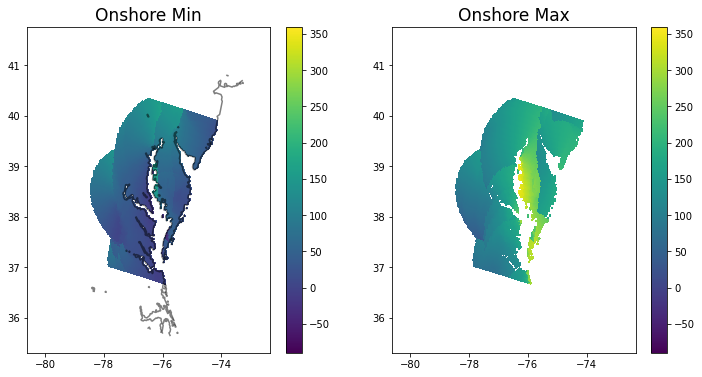

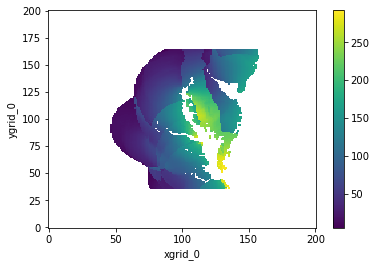

In [10]:
print(np.nanmin(onshore_min),np.nanmin(onshore_max))
print(np.nanmax(onshore_min),np.nanmax(onshore_max))
fig,ax = plt.subplots(ncols=2,figsize=(12,6))
dist_plt = ax[0].pcolormesh(lon,lat,onshore_min,norm=Normalize(-90,360),cmap=plt.cm.viridis)
plt.colorbar(dist_plt,ax=ax[0])
ax[0].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[0].set_title('Onshore Min',size=17)
deg_plt = ax[1].pcolormesh(lon,lat,onshore_max,norm=Normalize(-90,360),cmap=plt.cm.viridis)
plt.colorbar(deg_plt,ax=ax[1])
#ax[1].contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
ax[1].set_title('Onshore Max',size=17)
plt.show()
(onshore_max - onshore_min).plot()
plt.show()

In [11]:
for ww,hrrrout_file in enumerate(hrrr_files):
    print(hrrrout_file)
    for key in hrrrMD.variables:
        if 'precipitation' in hrrrMD[key].long_name:
            print(key,hrrrMD[key].long_name)

Land cover (1=land, 0=sea)
Geopotential height
latitude
longitude
Temperature
Potential temperature
U-component of wind
Specified height level above ground
V-component of wind
Pressure
Geopotential height
Isobaric surface
Temperature
Isobaric surface
U-component of wind
Isobaric surface
V-component of wind
Low cloud cover
Total cloud cover
Medium cloud cover
High cloud cover
Total precipitation


In [15]:
hrrr_detection_file

'/Users/hawbecke/Research/Chesapeake/Data/HRRR//forecast/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'

In [27]:
hrrr_detection_file

'/Users/hawbecke/Research/Chesapeake/Data/HRRR//forecast/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'

In [24]:
show_plot = False
init_vars = True

check_clouds = True
check_rain   = True

hrrr_type = 'forecast'

if hrrr_type == 'forecast':
    hrrr_detection_file = '{}/forecast/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'.format(hrrr_dir)
else:
    hrrr_detection_file = '{}/spatial_breeze_detection_HRRR_CLDnRAIN_abs.nc'.format(hrrr_dir)

if path.exists(hrrr_detection_file):
    print('loading in HRRR dataset!')
    breeze_ds_f = xr.open_dataset(hrrr_detection_file)
else:
    for ww,hrrrout_file in enumerate(hrrr_files):
        print(hrrrout_file)
        #hrrr = xr.open_dataset(hrrrout_file)
        #hrrrMD = hrrr.sel(xgrid_0=slice(xs,xs+span),ygrid_0=slice(ys,ys+span))
        hrrrMD = xr.open_dataset(hrrrout_file)

        out_time = pd.to_datetime(hrrrMD.TMP_P0_L103_GLC0.initial_time,format='%m/%d/%Y (%H:%M)')
        if hrrr_type == 'forecast':
            out_time += pd.to_timedelta(hrrrMD.TMP_P0_L103_GLC0.forecast_time,'h')
        if (out_time.hour >=13) & (out_time.hour <=22):
            time_str = date.strftime(out_time,'%Y-%m-%d %H:%M')
            print(time_str)
            if init_vars:
                land_mask  = np.squeeze(hrrrMD.LAND_P0_L1_GLC0)
                hgt        = np.squeeze(hrrrMD.HGT_P0_L1_GLC0)
                water_mask = land_mask.copy().where(land_mask==0.0) + 1.0
                lat  = hrrrMD.gridlat_0
                lon  = hrrrMD.gridlon_0
            onshore_min = onshore_min_max_ds.onshore_min
            onshore_max = onshore_min_max_ds.onshore_max

            breeze_ds = spatial_breeze_check(onshore_min,
                                             onshore_max,
                                             hrrrMD,
                                             land_mask=land_mask,
                                             wdir_check='vertical',
                                             dT_cutoff_pct=40.0,
                                             model='HRRR',
                                             check_clouds=check_clouds,
                                             check_rain=check_rain
                                            )
            
            if init_vars:
                breeze_ds_f = breeze_ds.copy()
                init_vars = False
            else:
                breeze_ds_f = breeze_ds.combine_first(breeze_ds_f) 



            if show_plot:
                t2   = hrrrMD.POT_P0_L103_GLC0.where(land_mask == 1.0)
                u10  = hrrrMD.UGRD_P0_L103_GLC0.sel(lv_HTGL2=10.0)
                v10  = hrrrMD.VGRD_P0_L103_GLC0.sel(lv_HTGL2=10.0)
                vel10 = (u10**2 + v10**2)**0.5
                dir10 = 180. + np.degrees(np.arctan2(u10, v10))
                vel10 = vel10.where(land_mask == 1.0)
                dir10 = dir10.where(land_mask == 1.0)

                fig = plt.figure(figsize=(16,20))
                nrow,ncol = 4,4
                dT_lvl = np.nanmax(abs(breeze_ds.dT_full.sel(datetime=time_str)))
                tmp_plt = plt.subplot2grid((nrow,ncol),(0,0),colspan=2,aspect='equal')
                tmp_plt_pc = tmp_plt.pcolormesh(lon,lat,breeze_ds.dT_full.sel(datetime=time_str),
                                                cmap=plt.cm.RdYlBu,norm=Normalize(-dT_lvl,dT_lvl))
                tmp_cbar = plt.colorbar(tmp_plt_pc,ax=tmp_plt)
                tmp_cbar.ax.tick_params(labelsize=13)
                tmp_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                tmp_plt.contour(lon,lat,breeze_ds.dT.sel(datetime=time_str),levels=[breeze_ds.dT_cutoff],colors='limegreen')
                tmp_plt.tick_params(labelsize=15,labelbottom=False)
                tmp_plt.set_title('T2',size=18)


                vel_plt = plt.subplot2grid((nrow,ncol),(1,0),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                vel_plt_pc = vel_plt.pcolormesh(lon,lat,vel10,cmap=plt.cm.YlOrRd)
                vel_cbar = plt.colorbar(vel_plt_pc,ax=vel_plt)
                vel_cbar.ax.tick_params(labelsize=13)
                vel_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                vel_plt.contour(lon,lat,breeze_ds.dU.sel(datetime=time_str),levels=[0.5],colors='b')
                vel_plt.tick_params(labelsize=15)
                vel_plt.set_title('Wind Speed',size=18)

                ons_plt = plt.subplot2grid((nrow,ncol),(0,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                ons_plt_pc = ons_plt.pcolormesh(lon,lat,onshore_min,cmap=plt.cm.viridis,norm=Normalize(0,360))
                ons_cbar = plt.colorbar(ons_plt_pc,ax=ons_plt)
                ons_cbar.ax.tick_params(labelsize=13)
                ons_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                ons_plt.tick_params(labelsize=15,labelbottom=False)
                ons_plt.set_title('Onshore Min',size=18)

                dir_plt = plt.subplot2grid((nrow,ncol),(1,2),colspan=2,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                dir_plt_pc = dir_plt.pcolormesh(lon,lat,dir10,cmap=plt.cm.viridis,norm=Normalize(0,360))
                dir_cbar = plt.colorbar(dir_plt_pc,ax=dir_plt)
                dir_cbar.ax.tick_params(labelsize=13)
                dir_plt.contour(lon,lat,land_mask,levels=[0.5],colors='k',alpha=0.5)
                qint = 7
                dir_plt.quiver(lon[::qint,::qint],lat[::qint,::qint],u10[::qint,::qint],v10[::qint,::qint])
                #dir_plt.contour(lon,lat,onshore_winds,levels=[1.0],colors='r')
                dir_plt.contour(lon,lat,breeze_ds.good_wdir.sel(datetime=time_str),levels=[1.0],colors='r')
                dir_plt.tick_params(labelsize=15)
                dir_plt.set_title('Wind Direction',size=18)


                crt_plt = plt.subplot2grid((nrow,ncol),(2,0),rowspan=2,colspan=4,aspect='equal',sharex=tmp_plt,sharey=tmp_plt)
                crt_plt_pc = crt_plt.pcolormesh(lon,lat,land_mask,cmap=plt.cm.binary,norm=Normalize(0,5.0))
                #plt.colorbar(crt_plt_pc,ax=crt_plt)
                crt_plt.contour(lon,lat,breeze_ds.good_wdir.sel(datetime=time_str),levels=[1.0],colors='r',alpha=0.5)
                crt_plt.contour(lon,lat,breeze_ds.dT.sel(datetime=time_str),levels=[breeze_ds.dT_cutoff],colors='limegreen',alpha=0.5)
                crt_plt.contour(lon,lat,breeze_ds.dU.sel(datetime=time_str),levels=[0.5],colors='b',alpha=0.5)
                crt_plt.plot(0.0,0.0,c='r',label='Wind Direction')
                crt_plt.plot(0.0,0.0,c='limegreen',label='∆T > 0')
                crt_plt.plot(0.0,0.0,c='b',label='Wind Ramp')
                crt_plt.set_xlim(np.nanmin(lon),np.nanmax(lon))
                crt_plt.set_ylim(np.nanmin(lat),np.nanmax(lat))
                good_areas = crt_plt.contourf(lon,lat,breeze_ds.breeze.sel(datetime=time_str),levels=[1.9,4.1],colors='k',
                                              alpha=0.25,hatches=['+++', '/'],label='Test')
                artists, labels = good_areas.legend_elements()
                #crt_plt.legend(artists, ['Good Points'], handleheight=2)
                crt_plt.legend(frameon=False,fontsize=18,loc=4)
                crt_plt.tick_params(labelsize=15)
                crt_plt.set_title(time_str,size=18)



                if check_clouds: crt_plt.contour(lon,lat,breeze_ds.is_cloudy.sel(datetime=time_str),levels=[0.5],colors='m')

                if check_rain: crt_plt.contour(lon,lat,breeze_ds.is_raining.sel(datetime=time_str),levels=[0.5],colors='c')


                for ss,stn in enumerate(near_shore_stations):
                    stn_color = int(breeze_ds.breeze.sel(datetime=time_str,
                                                       ygrid_0=stn_dict[stn]['j'],
                                                       xgrid_0=stn_dict[stn]['i']).data)
                    crt_plt.scatter(stn_dict[stn]['lon'],stn_dict[stn]['lat'],
                                facecolor=breeze_cmap[stn_color],s=100,
                                edgecolor='k',zorder=4,alpha=0.65)
                    crt_plt.text(stn_dict[stn]['lon']-0.1,stn_dict[stn]['lat'],stn,size=13,ha='right',va='center')


                plt.show()




    breeze_ds_f['onshore_min'] = onshore_min
    breeze_ds_f['onshore_max'] = onshore_max
    breeze_ds_f['land_mask'] = land_mask

    breeze_ds_f.attrs = {'HRRR_DIR':'/'.join(hrrr_files[0].split('/')[:-1])}

    breeze_ds_f.to_netcdf(hrrr_detection_file)

/Users/hawbecke/Research/Chesapeake/Data/HRRR/forecast/hrrr.20190716.t06z.wrfsfcf07.nc
2019-07-16 13:00
mean near shore: 0.002084561623632908
inland: 0.0019275572849437594
pct near shore: 0.001897299918346107
inland: 0.0018627126235514879
Whole domain is stable.. checking near shore
Near shore also stable...
cutoff all: nan
/Users/hawbecke/Research/Chesapeake/Data/HRRR/forecast/hrrr.20190716.t06z.wrfsfcf08.nc
2019-07-16 14:00
mean near shore: 0.0009856878314167261
inland: 0.000650679343380034
pct near shore: 0.0008134953794069589
inland: 0.0004844756156671793
Whole domain is stable.. checking near shore
Near shore also stable...
cutoff all: nan
/Users/hawbecke/Research/Chesapeake/Data/HRRR/forecast/hrrr.20190716.t06z.wrfsfcf09.nc
2019-07-16 15:00
mean near shore: 6.847541953902692e-05
inland: -0.00022454866848420352
pct near shore: -0.00013038260221946983
inland: -0.0004171338863670826
Whole domain is neutral or convective. Calculating dT_cutoff over whole domain.
cutoff all: 0.0
/User

In [16]:
breeze_ds_dict = {}
breeze_ds_dict['HRRR'] = breeze_ds_f

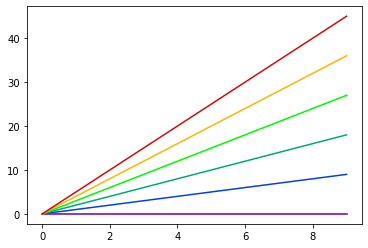

In [17]:
stn_colors = plt.cm.nipy_spectral(np.linspace(0.05,0.95,len(near_shore_stations)))
for ss,stn in enumerate(near_shore_stations):    
    plt.plot(np.arange(0,10),np.arange(0,10)*ss,c=stn_colors[ss])

/Users/hawbecke/.conda/envs/pyhawbeck/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: The following kwargs were not used by contour: 'label'


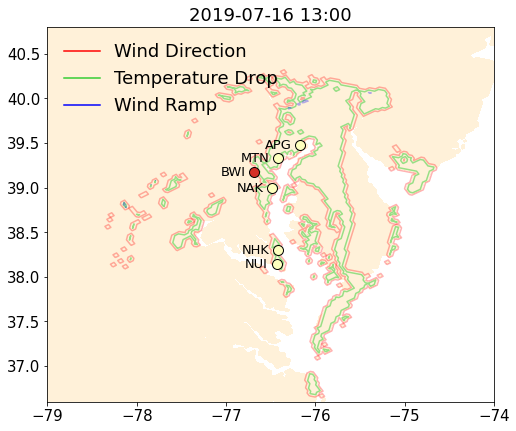

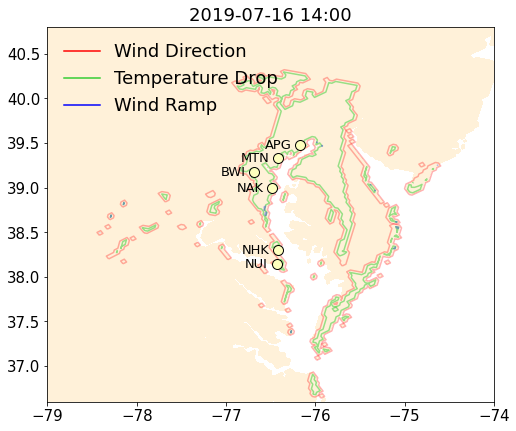

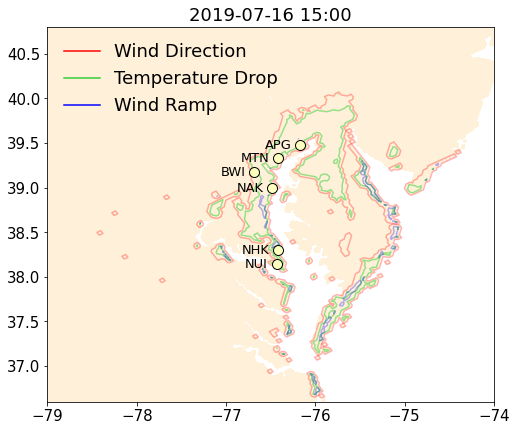

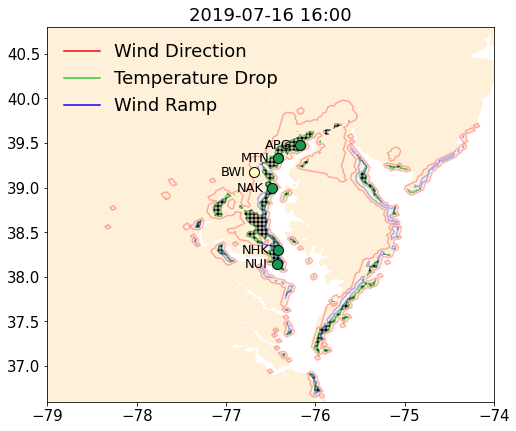

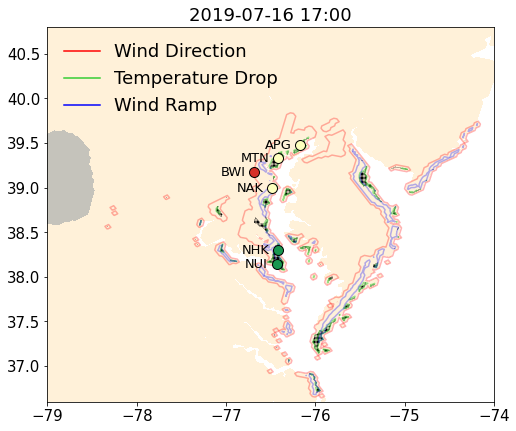

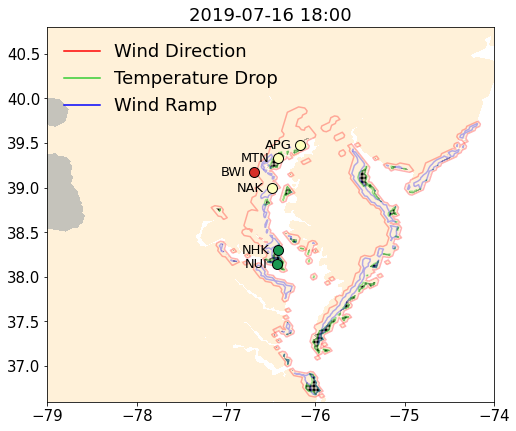

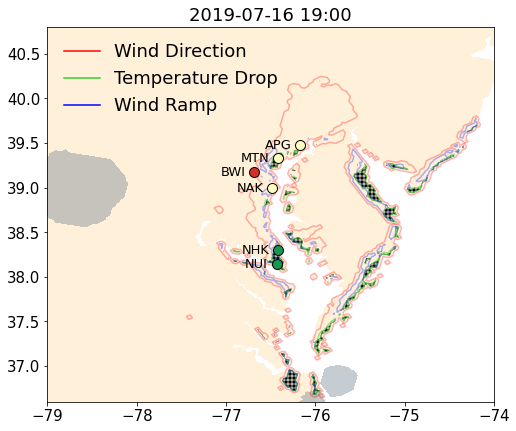

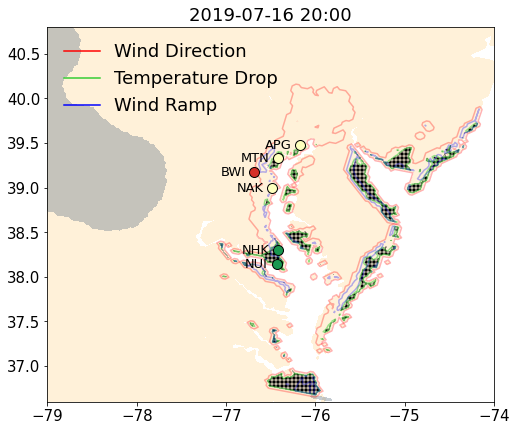

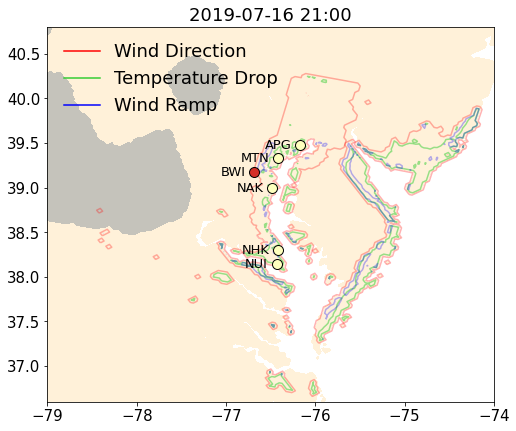

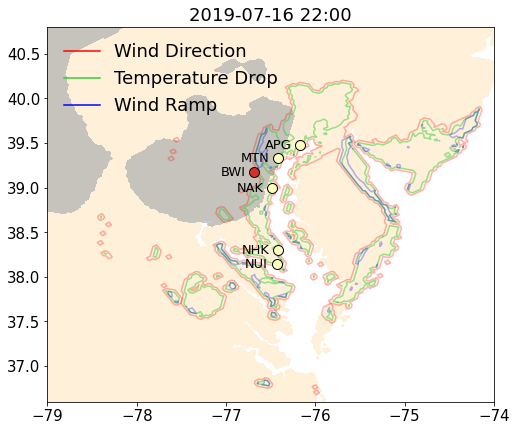

In [20]:
for time in breeze_ds_f.datetime[:10]:
    lon = breeze_ds_f.gridlon_0
    lat = breeze_ds_f.gridlat_0
    plt.figure(figsize=(8,8))
    plt.subplot2grid((1,1),(0,0),aspect='equal')
    plt.contourf(lon,lat,breeze_ds_f.land_mask,colors='moccasin',levels=[0.5,1.0],alpha=0.5)
    plt.contour(lon,lat,breeze_ds_f.good_wdir.sel(datetime=time),levels=[1.0],colors='r',alpha=0.3)
    plt.contour(lon,lat,breeze_ds_f.dT.sel(datetime=time),levels=[0.0001],colors='limegreen',alpha=0.5)
    plt.contour(lon,lat,breeze_ds_f.dU.sel(datetime=time),levels=[0.5],colors='b',alpha=0.3)
    plt.plot(0.0,0.0,c='r',label='Wind Direction')
    plt.plot(0.0,0.0,c='limegreen',label='Temperature Drop')
    plt.plot(0.0,0.0,c='b',label='Wind Ramp')
    #plt.xlim(np.nanmin(lon),np.nanmax(lon))
    #plt.ylim(np.nanmin(lat),np.nanmax(lat))
    plt.ylim(36.6,40.8)
    plt.xlim(-79.0,-74.0)
    good_areas = plt.contourf(lon,lat,breeze_ds_f.breeze.sel(datetime=time),levels=[1.9,4.1],colors='k',
                                  alpha=0.25,hatches=['+++', '/'],label='Test')
    artists, labels = good_areas.legend_elements()
    #crt_plt.legend(artists, ['Good Points'], handleheight=2)
    plt.legend(frameon=False,fontsize=18,loc=2)
    plt.tick_params(labelsize=15)
    plt.title(date.strftime(pd.to_datetime(time.data),'%Y-%m-%d %H:%M'),size=18)
    for ss,stn in enumerate(near_shore_stations):
        stn_color = int(breeze_ds_f.breeze.sel(datetime=time,
                                               ygrid_0=stn_dict[stn]['j'],
                                               xgrid_0=stn_dict[stn]['i']).data)
        plt.scatter(stn_dict[stn]['lon'],stn_dict[stn]['lat'],
                    facecolor=breeze_cmap[stn_color],s=100,
                    edgecolor='k',zorder=4)
        plt.text(stn_dict[stn]['lon']-0.1,stn_dict[stn]['lat'],stn,size=13,ha='right',va='center')



    if check_clouds: plt.contourf(lon,lat,breeze_ds_f.is_cloudy.sel(datetime=time),levels=[0.5,1.0],colors='slategray',alpha=0.4)

    if check_rain: plt.contourf(lon,lat,breeze_ds_f.is_raining.sel(datetime=time),levels=[0.5,1.0],colors='c',alpha=0.25)


    plt.show()
    

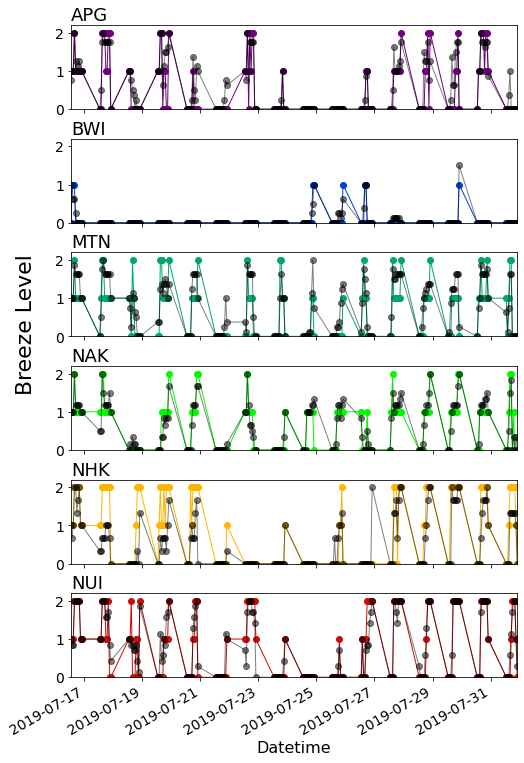

In [26]:
for cc,case in enumerate(list(breeze_ds_dict.keys())):
    fig,ax = plt.subplots(nrows=len(near_shore_stations),figsize=(8,12),sharex=True)
    fig.subplots_adjust(hspace=0.35)
    for ss,stn in enumerate(near_shore_stations):

        if case == 'HRRR':
            stn_color = breeze_ds_f.breeze.sel(ygrid_0=stn_dict[stn]['j'],
                                               xgrid_0=stn_dict[stn]['i'])
            surrounding_points = breeze_ds_f.breeze.sel(ygrid_0=slice(stn_dict[stn]['j']-1,stn_dict[stn]['j']+2),
                                                        xgrid_0=slice(stn_dict[stn]['i']-1,stn_dict[stn]['i']+2)).copy()
            surrounding_points.sel(xgrid_0=1,ygrid_0=1).data[:] = surrounding_points.sel(xgrid_0=1,ygrid_0=1).data[:]*np.nan
            avg_surrounding_points = surrounding_points.mean(dim=['ygrid_0','xgrid_0'])

        else:
            stn_color = breeze_ds_f.breeze.sel(south_north=stn_dict[stn]['j'],
                                               west_east=stn_dict[stn]['i'])
            surrounding_points = breeze_ds_f.breeze.sel(south_north=slice(stn_dict[stn]['j']-1,stn_dict[stn]['j']+2),
                                                   west_east=slice(stn_dict[stn]['i']-1,stn_dict[stn]['i']+2)).copy()
            surrounding_points.sel(west_east=1,south_north=1).data[:] = surrounding_points.sel(west_east=1,south_north=1).data[:]*np.nan
            avg_surrounding_points = surrounding_points.mean(dim=['south_north','west_east'])

        stn_color.plot(marker='o',lw=1.0,c=stn_colors[ss],label=stn,ax=ax[ss])
        avg_surrounding_points.plot(marker='o',lw=1.0,c='k',label=stn,ax=ax[ss],alpha=0.5)
        ax[ss].tick_params(labelsize=14)
        if ss == 3:
            ax[ss].set_ylabel('Breeze Level',size=22,y=1.5,labelpad=19.4)
        else:
            ax[ss].set_ylabel('',size=16)            
        ax[ss].set_title('')
        ax[ss].set_xlabel('',size=16)
        ax[ss].text(stn_color.datetime.data[0],2.21,stn,va='bottom',size=18)#,color=stn_colors[ss])
        ax[ss].set_ylim(0,2.2)
    ax[0].set_xlim(stn_color.datetime.data[0],stn_color.datetime.data[-1])
    #ax[0].set_xlim('2019-07-19 00:00:00','2019-07-21 00:00:00')
    ax[-1].set_xlabel('Datetime',size=16)
    plt.show()
    

In [27]:
def find_max_in_row(x):
    expected_x = x[0] + 1
    count = 1
    max_count = 1
    for i in x[1:]:
        if i == expected_x:
            count += 1
            expected_x += 1
            if count > max_count: max_count = count
        else:
            if count > max_count: max_count = count
            count = 1
            expected_x = i + 1
    return(max_count)

In [28]:
bb_observed_dates = {
                     'StaufferThompson2015' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-02' : ['MTN', 'APG'],
                                               '2019-07-04' : ['NHK', 'NUI'],
                                               '2019-07-06' : ['MTN', 'APG'],
                                               '2019-07-09' : ['NAK', 'MTN'],
                                               '2019-07-10' : ['NHK', 'NUI'],
                                               '2019-07-15' : ['NAK'],
                                               '2019-07-16' : ['NAK', 'NHK', 'MTN'],
                                               '2019-07-17' : ['MTN', 'NAK'],
                                               '2019-07-19' : ['NAK', 'MTN', 'NHK', 'APG'],
                                               '2019-07-22' : ['MTN'],
                                               '2019-07-24' : ['NUI', 'NUI', 'NAK'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-26' : ['MTN', 'BWI'],
                                               '2019-07-27' : ['NAK', 'MTN', 'NHK'],
                                               '2019-07-28' : ['MTN', 'NAK', 'NAK', 'NHK'],
                                               '2019-07-29' : ['MTN', 'NAK', 'NHK'],
                                               '2019-07-30' : ['MTN', 'NAK', 'NHK'],
                                               '2019-07-31' : ['NHK'],
                                              },
                     'Stauffer2015' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-04' : ['NHK'],
                                               '2019-07-10' : ['NHK'],
                                               '2019-07-15' : ['NAK'],
                                               '2019-07-16' : ['NAK'],
                                               '2019-07-17' : ['NAK'],
                                               '2019-07-19' : ['NHK'],
                                               '2019-07-27' : ['NAK', 'NAK', 'NHK'],
                                               '2019-07-28' : ['NAK'],
                                               '2019-07-29' : ['NAK', 'NHK'],
                                               '2019-07-30' : ['NAK', 'NHK'],
                                               '2019-07-31' : ['NHK'],
                                              },
                     'Sikora2010' : {
                                               '2019-07-01' : ['NAK'],
                                               '2019-07-05' : ['BWI'],
                                               '2019-07-10' : ['NUI'],
                                               '2019-07-16' : ['NAK'],
                                               '2019-07-24' : ['NUI', 'NAK'],
                                               '2019-07-25' : ['NAK'],
                                               '2019-07-27' : ['NHK'],
                                               '2019-07-28' : ['NAK', 'NHK'],
                                              },
                     }

In [29]:
for mm,method in enumerate(bb_observed_dates.keys()):
    if mm == 0:
        all_observed_dates = bb_observed_dates[method].copy()
    else:
        for day in bb_observed_dates[method]:
            if day not in list(all_observed_dates):
                all_observed_dates[day] = bb_observed_dates[method][day]
            else: # check to see if the station on this date is already included
                if bb_observed_dates[method][day] != all_observed_dates[day]:
                    new_list = list(np.unique(np.append(bb_observed_dates[method][day], all_observed_dates[day])))
                    all_observed_dates[day] = new_list
                    
            
for day in all_observed_dates:
    print(day,all_observed_dates[day])

2019-07-01 ['NAK']
2019-07-02 ['MTN', 'APG']
2019-07-04 ['NHK', 'NUI']
2019-07-06 ['MTN', 'APG']
2019-07-09 ['NAK', 'MTN']
2019-07-10 ['NHK', 'NUI']
2019-07-15 ['NAK']
2019-07-16 ['MTN', 'NAK', 'NHK']
2019-07-17 ['MTN', 'NAK']
2019-07-19 ['APG', 'MTN', 'NAK', 'NHK']
2019-07-22 ['MTN']
2019-07-24 ['NAK', 'NUI']
2019-07-25 ['NAK']
2019-07-26 ['MTN', 'BWI']
2019-07-27 ['MTN', 'NAK', 'NHK']
2019-07-28 ['MTN', 'NAK', 'NHK']
2019-07-29 ['MTN', 'NAK', 'NHK']
2019-07-30 ['MTN', 'NAK', 'NHK']
2019-07-31 ['NHK']
2019-07-05 ['BWI']


HRRR
APG 136 104
BWI 121 92
MTN 129 98
NAK 116 99
NHK 91 107
NUI 86 108


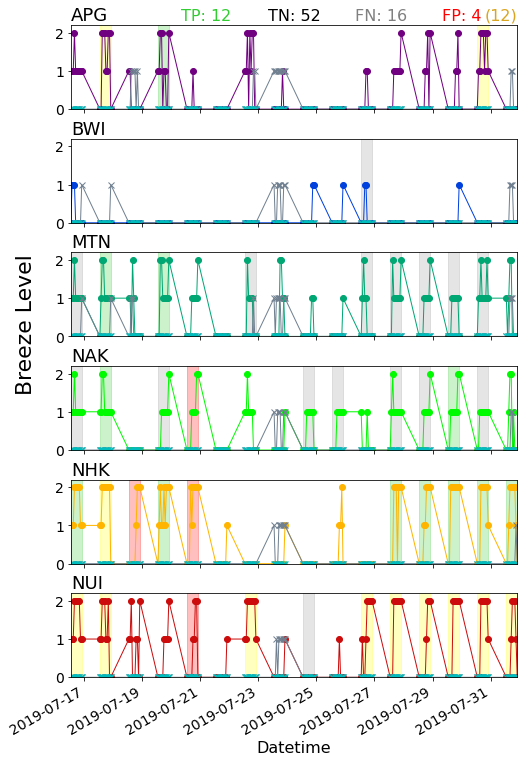

In [31]:
show_plot = True
use_neighbors = False
use_all_days = True
period_start = pd.to_datetime('2019-07-16 00:00:00')
period_end   = breeze_ds_f.datetime.data[-1]

cMatrix_color_dict = {'TP':'limegreen',
                      'FP':'red',
                      'FN':'grey',
                   'close':'yellow',
                      'TN':'k'}



for cc,case in enumerate(list(breeze_ds_dict.keys())):
    breeze_ds_f = breeze_ds_dict[case]
    cMatrix_dict = {'TP':0,
                    'TN':0,
                    'FP':0,
                    'FN':0,
                 'close':0}
    print(case)
    fig,ax = plt.subplots(nrows=len(near_shore_stations),figsize=(8,12),sharex=True)
    fig.subplots_adjust(hspace=0.35)
    for ss,stn in enumerate(near_shore_stations):


        if case == 'HRRR':
            print(stn,stn_dict[stn]['j'],stn_dict[stn]['i'])
            stn_bb_ds = breeze_ds_f.sel(ygrid_0=stn_dict[stn]['j'],
                                        xgrid_0=stn_dict[stn]['i'])
            surrounding_points = breeze_ds_f.breeze.sel(ygrid_0=slice(stn_dict[stn]['j']-1,stn_dict[stn]['j']+2),
                                                        xgrid_0=slice(stn_dict[stn]['i']-1,stn_dict[stn]['i']+2)).copy()
            surrounding_points.sel(xgrid_0=1,ygrid_0=1).data[:] = surrounding_points.sel(
                                                                        xgrid_0=1,ygrid_0=1).data[:]*np.nan
            avg_surrounding_points = surrounding_points.mean(dim=['ygrid_0','xgrid_0'])
        else:
            stn_bb_ds = breeze_ds_f.sel(south_north=stn_dict[stn]['j'],west_east=stn_dict[stn]['i'],
                                        datetime=slice(period_start,period_end))
            
            surrounding_points = breeze_ds_f.breeze.sel(south_north=slice(stn_dict[stn]['j']-1,stn_dict[stn]['j']+2),
                                                   west_east=slice(stn_dict[stn]['i']-1,stn_dict[stn]['i']+2)).copy()
            surrounding_points.sel(west_east=1,south_north=1).data[:] = surrounding_points.sel(
                                                                        west_east=1,south_north=1).data[:]*np.nan
            avg_surrounding_points = surrounding_points.mean(dim=['south_north','west_east'])
        stn_color = stn_bb_ds.breeze
        stn_cloud = stn_bb_ds.is_cloudy
        stn_rain  = stn_bb_ds.is_raining
        if use_neighbors:
            avg_surrounding_points.plot(marker='o',lw=1.0,c='k',label=stn,ax=ax[ss],alpha=0.5)
        stn_color.plot(marker='o',lw=1.0,c=stn_colors[ss],label=stn,ax=ax[ss])
        stn_cloud.plot(marker='x',lw=1.0,c='slategray',label=stn,ax=ax[ss])
        stn_rain.plot(marker='x',lw=1.0,c='c',label=stn,ax=ax[ss])

        ax[ss].tick_params(labelsize=14)
        if ss == 3:
            ax[ss].set_ylabel('Breeze Level',size=22,y=1.5,labelpad=19.4)
        else:
            ax[ss].set_ylabel('',size=16)            
        ax[ss].set_title('')
        ax[ss].set_xlabel('',size=16)
        ax[ss].text(stn_color.datetime.data[0],2.21,stn,va='bottom',size=18)#,color=stn_colors[ss])
        ax[ss].set_ylim(0,2.2)
        for dd,day in enumerate(pd.date_range(start=period_start, end=period_end)):
            
            day_str = '{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day)
            fill_color = None
            if use_all_days:
                observed_days = all_observed_dates.copy()
                
                if day_str in list(observed_days.keys()): # If model detects a breeze, what fill color will it be?
                    if stn in observed_days[day_str]: # Station is observed AND simulated
                        fill_color = cMatrix_color_dict['TP']
                    else:
                        #print(day,stn,observed_days[day_str]) # Day had BB but station didn't observe it
                        fill_color = cMatrix_color_dict['close']
                else:
                    fill_color = cMatrix_color_dict['FP'] # No observed BBs on this day
                
            else: # Only using ST currently... need to figure this out if going to use.
                observed_days = bb_observed_dates[method].copy()
            
                for mm,method in enumerate(list(bb_observed_dates.keys())[:1]):
                    if day_str in list(observed_days.keys()):
                        if stn in observed_days[day_str]:
                            fill_color = 'green'
                        else:
                            fill_color = 'yellow'
                    else:
                        fill_color = 'red'


            #print('{0:04d}-{1:02d}-{2:02d}'.format(day.year,day.month,day.day))
            bb_day    = stn_color.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            cloud_day = stn_cloud.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            rain_day  = stn_rain.sel(datetime=slice(day,day+pd.to_timedelta(23,'h'))).copy()
            cloud_tot = cloud_day.sum().data
            rain_tot  = rain_day.sum().data

            bb_no_clouds = bb_day * ((cloud_day - 1.0)*-1)

            bb_eq_2 = np.where(bb_no_clouds.data==2.0)[0]
            rainy_or_cloudy = (rain_tot > 1.0)# or (cloud_tot > 1.0)
            
            if len(bb_eq_2) >= 1:
                max_count = find_max_in_row(bb_eq_2)
            else:
                max_count = 0
            if use_neighbors:
                avg_surrounding_points_day = avg_surrounding_points.sel(datetime=slice(
                                                                        day,day+pd.to_timedelta(23,'h'))).copy()
                neighbor_gt_1p5 = np.where(avg_surrounding_points_day.data>=1.25)[0]    
                if len(neighbor_gt_1p5) >= 2:
                    max_neighbor_count = find_max_in_row(neighbor_gt_1p5)
                else:
                    max_neighbor_count = 0
                if (max_count >= 3) & (max_neighbor_count >= 2):
                    ax[ss].fill_betweenx([0,4],day,day+pd.to_timedelta(10,'h'),color=fill_color,alpha=0.15)
                
            else:
                if (max_count >= 2) and (not rainy_or_cloudy):
                    ax[ss].fill_betweenx([0,4],bb_day.datetime.data[0],bb_day.datetime.data[-1],
                                         color=fill_color,alpha=0.25)
                    if fill_color == cMatrix_color_dict['TP']:
                        cMatrix_dict['TP'] += 1
                    elif fill_color == cMatrix_color_dict['FP']: # or fill_color == cMatrix_color_dict['close']:
                        cMatrix_dict['FP'] += 1
                    elif fill_color == cMatrix_color_dict['close']:
                        cMatrix_dict['close'] += 1
                        
                else:
                    if fill_color == cMatrix_color_dict['TP']:
                        fill_color = cMatrix_color_dict['FN']
                        cMatrix_dict['FN'] += 1
                        ax[ss].fill_betweenx([0,4],bb_day.datetime.data[0],bb_day.datetime.data[-1],
                                             color=fill_color,alpha=0.2)
                    else:
                        cMatrix_dict['TN'] += 1
            #print(day,stn,max_count,max_neighbor_count)
    
    ax[0].set_xlim(stn_color.datetime.data[0],stn_color.datetime.data[-1])
    #ax[0].set_xlim('2019-07-19 00:00:00','2019-07-21 00:00:00')
    ax[-1].set_xlabel('Datetime',size=16)
    
    cMatrix_list = ['TP','TN','FN','FP']
    for cm,cMatrix in enumerate(cMatrix_list):
        str_x = pd.to_datetime('2019-07-20 08:00:00') + pd.to_timedelta(cm*3,'d')
        cMatrix_str = '{}: {}'.format(cMatrix,cMatrix_dict[cMatrix])
        ax[0].text(str_x,2.25,cMatrix_str,ha='left',va='bottom',size=16,
                   color=cMatrix_color_dict[cMatrix])
        if cMatrix == 'FP':
            str_x = stn_color.datetime.data[-1]
            ax[0].text(str_x,2.25,'({})'.format(cMatrix_dict['close']),ha='right',va='bottom',size=16,
                       color='goldenrod')#color=cMatrix_color_dict['close'])
        
    plt.show()
    
            
        
